In [16]:
import zipfile

data = "datasets/nfl-big-data-bowl-2024.zip"
filelist = []
with zipfile.ZipFile(data, mode="r") as archive:
    filelist = archive.namelist()

Note the size differences.  The week by week tracking data is huge.  Why?

In [4]:
with zipfile.ZipFile(data, mode="r") as archive:
    archive.printdir()

File Name                                             Modified             Size
games.csv                                      2023-09-29 16:41:58         8330
players.csv                                    2023-09-29 16:42:00       103939
plays.csv                                      2023-09-29 16:42:00      3546466
tackles.csv                                    2023-09-29 16:42:02       535391
tracking_week_1.csv                            2023-09-29 16:42:08    185611101
tracking_week_2.csv                            2023-09-29 16:42:22    180879231
tracking_week_3.csv                            2023-09-29 16:42:36    186867093
tracking_week_4.csv                            2023-09-29 16:42:48    186949967
tracking_week_5.csv                            2023-09-29 16:43:02    194650924
tracking_week_6.csv                            2023-09-29 16:43:12    164721387
tracking_week_7.csv                            2023-09-29 16:43:24    170426365
tracking_week_8.csv                     

Load all the files into a data dictionary.

In [19]:
data_dict = dict()
with zipfile.ZipFile(data,mode="r") as archive:
    for filename in archive.namelist():
        #for line in archive.read(filename).split(b"\n"):
            #print(filename)
        data_dict[filename] = pd.read_csv(archive.open(filename))

In [313]:
#games = filelist[0]
games_df = data_dict['games.csv']
players_df = data_dict["players.csv"]
tackles_df = data_dict["tackles.csv"]

In [117]:
players_df.columns

Index(['nflId', 'height', 'weight', 'birthDate', 'collegeName', 'position',
       'displayName'],
      dtype='object')

In [120]:
tackles_df.columns

Index(['gameId', 'playId', 'nflId', 'tackle', 'assist', 'forcedFumble',
       'pff_missedTackle'],
      dtype='object')

In [113]:
# Data for 32 NFL teams for 9 weeks of a season but not for all games
games_df["homeTeamAbbr"].nunique()

32

In [114]:
len(games_df)

136

Play by play, frame by frame tracking.  Each player position on the field at each frame number.

In [40]:
nfltracking2024  = pd.concat([data_dict[filename] for filename in filelist[-9:]])

In [94]:
nfltracking2024.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event'],
      dtype='object')

In [115]:
plays_df = data_dict['plays.csv']

91 plays in our sample game; so we also create a df restricted to 1 play

In [323]:
sampleId = 2022090800
playId = 2307
game_plays = plays_df[plays_df['gameId']==sampleId]
print(game_plays['playId'].nunique())
play_df = game_plays[game_plays['playId']==playId]
play_df['playId'].nunique()

91


1

In [102]:
game_plays.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

In [324]:
play_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
262,2022090800,2307,44881,Cooper Kupp,(7:28) (Shotgun) M.Stafford pass deep left to ...,3,2,10,LA,BUF,...,0.230606,0.769394,0.043359,-0.043359,0.805026,2.080663,NaN,NaN,NaN,NaN


Collecting info for that one play:

In [312]:
play_df = game_plays[game_plays['playId']==playId]
playDescription = play_df['playDescription'].values[0]
print(playDescription)dd

(7:28) (Shotgun) M.Stafford pass deep left to C.Kupp pushed ob at LA 48 for 23 yards (T.Johnson; C.Benford).


In [326]:
import re
play_df = game_plays[game_plays['playId']==playId]
yardlineNumber = play_df['yardlineNumber'].values[0]
quarter = play_df['quarter'].values[0]
down = play_df['down'].values[0]
yardsToGo = play_df['yardsToGo'].values[0]
playDescription = play_df['playDescription'].values[0]
# Play time is buried in description string.  
time = re.search(r"\d:\d\d", playDescription)[0]
# Read off the play description
displayName,displayName2 = "Cooper Kupp", "Matthew Stafford"
print(f"Quarter {quarter} {time} down {down} {yardsToGo} yards to go:  {displayName2} to {displayName}")

Quarter 3 7:28 down 2 10 yards to go:  Matthew Stafford to Cooper Kupp


We'll look more at this play below.  But here's a hint of where we're headed.

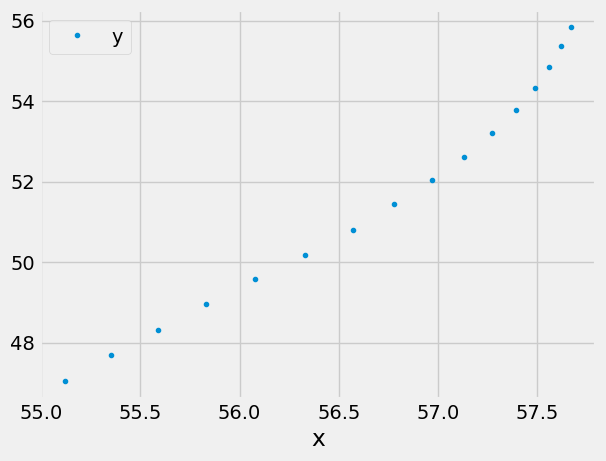

In [152]:
# Copied from above
sampleId = 2022090800
playId = 2307
gameId,displayName = sampleId, "Cooper Kupp"
play_player_bool = (nfltracking2024["gameId"] == gameId) & \
                      (nfltracking2024["playId"] == playId) & \
                          (nfltracking2024["displayName"] == displayName)
nfltracking2024[play_player_bool].plot(x='x', y='y', style='.')

In [258]:
play_player_bool2 = (plays_df["gameId"] == gameId) & \
                      (plays_df["playId"] == playId)
plays_df[play_player_bool2]['playResult']

262    23
Name: playResult, dtype: int64

In [331]:

import random
from matplotlib import pyplot as plt 
from datetime import date
import re
from cycler import cycler

stylesheetList = ['grayscale','ggplot','fivethirtyeight','Solarize_Light2','dark_background','bmh']


custom_cycler = (cycler(color=['b','k','m','g']))

def format_gameid (gameId):
    """
    game_df is globally defined
    """
    gameRow = games_df[(games_df["gameId"]==gameId)]
    gameId_str = f"{gameId}"
    vis, hm = gameRow["visitorTeamAbbr"].values[0], gameRow["homeTeamAbbr"].values[0]
    return f" {vis} vs. {hm} " + date(year=int(gameId_str[:4]),
                                      month=int(gameId_str[4:6]),
                                      day= int(gameId_str[6:8])).strftime("%m/%d/%Y")

def make_title(gameId,playId,displayName,displayName2):
    """
    plays_df and game_df are globally defined
    """
    #game_plays = plays_df[plays_df['gameId']==sampleId]
    play_df = plays_df[(plays_df['gameId']==sampleId)&(game_plays['playId']==playId)]
    yardlineNumber = play_df['yardlineNumber'].values[0]
    quarter = play_df['quarter'].values[0]
    down = play_df['down'].values[0]
    yardsToGo = play_df['yardsToGo'].values[0]
    #more general than 'passLength'
    playResult = round(play_df['playResult'].values[0])
    time = re.search(r"\d:\d\d", play_df['playDescription'].values[0])[0]
    #displayName,displayName2 = "Cooper Kupp", "Matthew Stafford"
    game_str = format_gameid (gameId)
    if displayName2 is not None:
        displayNames = f"{displayName2} to {displayName}"
    else:
        displayNames = f"{displayName}"
    print(f"Q{quarter} {time} down {down} {yardsToGo} yards to go at {yardlineNumber}:  "\
           f"{displayNames} for {playResult} yards {game_str}")
    
def draw_game(df, gameId, stylesheet=None):
    """
    Kalilur Rahman's visualization function (Kaggle) adapted.
    """
    if stylesheet is None:
        stylesheet = random.choice(stylesheetList)
    plt.style.use(stylesheet)
    fig, ax = plt.subplots(figsize=(12, 8))
    df.query(f'gameId == {gameId}').groupby('club').plot(x='x', y='y', ax=ax, style='.',)
    plt.title(format_gameid(gameId))
    plt.legend().remove()
    plt.tight_layout()
    plt.show()

def draw_game_play_position(df, gameId, playId, displayName, displayName2=None, stylesheet=None, ax=None,
                           scatter=False):
    """
    plays_df and game_df are globally defined
    custom_cycler is globally defined
    
    Kalilur Rahman's visualization function (Kaggle) adapted.
    """
    if stylesheet is None:
        stylesheet = random.choice(stylesheetList)
    plt.style.use(stylesheet)
    displayList = [displayName, "football"]
    if displayName2 is not None:
        displayList.append(displayName2)
    play_player_bool = (df["gameId"] == gameId) & \
                        (df["playId"] == playId) & \
                          (df["displayName"].isin(displayList))
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_prop_cycle(custom_cycler)
    if scatter:
        # Currently this gets an undiagnosed warning related to the legend and really doesnt look much differemt
        ax.legend_ = None
        df[play_player_bool].groupby('displayName').plot.scatter(x='x', y='y', ax=ax)
    else:
        # The idea is to get different colors for each displayName tracked
        df[play_player_bool].groupby('displayName').plot(x='x', y='y', ax=ax, style='.')
    #nfltracking2024.query(f'(gameId == {gameId}) & (playId == {playId})\
    #    & (displayName == {displayName})') ).groupby('club').plot(x='x', y='y', ax=ax, style='.')
    title = make_title(gameId,playId,displayName,displayName2)
    plt.title(title,fontsize=32)
    plt.legend().remove()
    plt.tight_layout()
    plt.show()


Here's the spaghetti dish the frame by frame data gives you for one game.

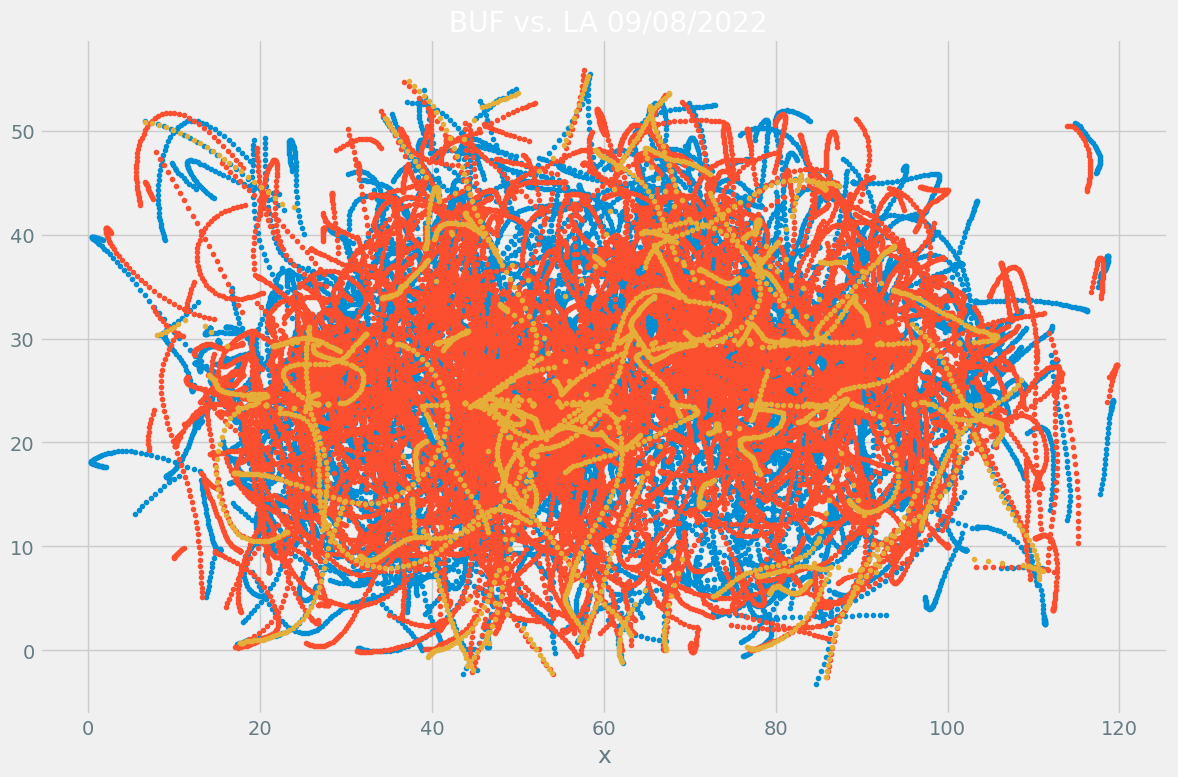

In [175]:
df = nfltracking2024
draw_game(df,sampleId ,stylesheet='fivethirtyeight')

Zoom in on one play in one game.

In [123]:
play_frames = nfltracking2024[(nfltracking2024['gameId']==sampleId) & (nfltracking2024['playId']==playId)]

In [263]:
# number of frames for a single play, each linked to a jersey number (or FOOTBALL)

len(play_frames)#,len(game_plays)

368

In [245]:
play_frames[play_frames['displayName']=='Cooper Kupp'][:5]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
45698,2022090800,2307,44881.0,Cooper Kupp,1,2022-09-08 22:08:00.700000,10.0,LA,right,55.12,47.05,6.85,1.89,0.69,327.89,20.18,NaN
45699,2022090800,2307,44881.0,Cooper Kupp,2,2022-09-08 22:08:00.799999,10.0,LA,right,55.35,47.69,6.78,1.42,0.68,333.00,20.21,NaN
45700,2022090800,2307,44881.0,Cooper Kupp,3,2022-09-08 22:08:00.900000,10.0,LA,right,55.59,48.32,6.68,1.38,0.67,337.71,20.41,pass_arrived
45701,2022090800,2307,44881.0,Cooper Kupp,4,2022-09-08 22:08:01.000000,10.0,LA,right,55.83,48.95,6.69,1.16,0.67,341.89,21.57,NaN
45702,2022090800,2307,44881.0,Cooper Kupp,5,2022-09-08 22:08:01.099999,10.0,LA,right,56.08,49.57,6.68,1.17,0.67,342.97,22.55,NaN


And all 91 plays are represented.

In [127]:
nfltracking2024[(nfltracking2024['gameId']==sampleId)]['playId'].nunique()

91

### Add the football field

This code is a nice example of using a customized matoplotlib background for plotting.

You can also use an image for a backdrop, but that's another story.

In [280]:
#football field - code from  https://www.kaggle.com/jaronmichal/tracking-data-visualization 
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


# Change size of the figure
plt.rcParams['figure.figsize'] = [24, 16]
def drawPitch(width=100, height=54, color="w",grasscolor='#3f995b'):
    #football field - code from  https://www.kaggle.com/jaronmichal/tracking-data-visualization 
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor=grasscolor, capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
            # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
                for j in range(1, 5):
                    plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
        ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax


def plot_play(df, gameId, playId, position):
    """
    not finished.
    """
    fig, ax = drawPitch()
    ax.set_prop_cycle(custom_cycler)
    #df.query('gameId == ' + gameId ).groupby('team').plot(x='x', y='y', ax=ax, style='.')
    df[(df['gameId'] == gameId) & (df['playId'] == gameId) & (df['position'] == position)]
    plt.title(' Plotting for gameId == ' + gameId ,fontsize=36,ha='center')
    plt.legend().remove()

### Track one or two players plus the football on one play 

Here's the play we looked at above plotted using the play tracking data.

Note that I read the description and know it's a pass from Matthew Stafford to Cooper Kupp:

Q3 7:28 down 2 10 yards to go at 25:  Matthew Stafford to Cooper Kupp for 23 yards  BUF vs. LA 09/08/2022


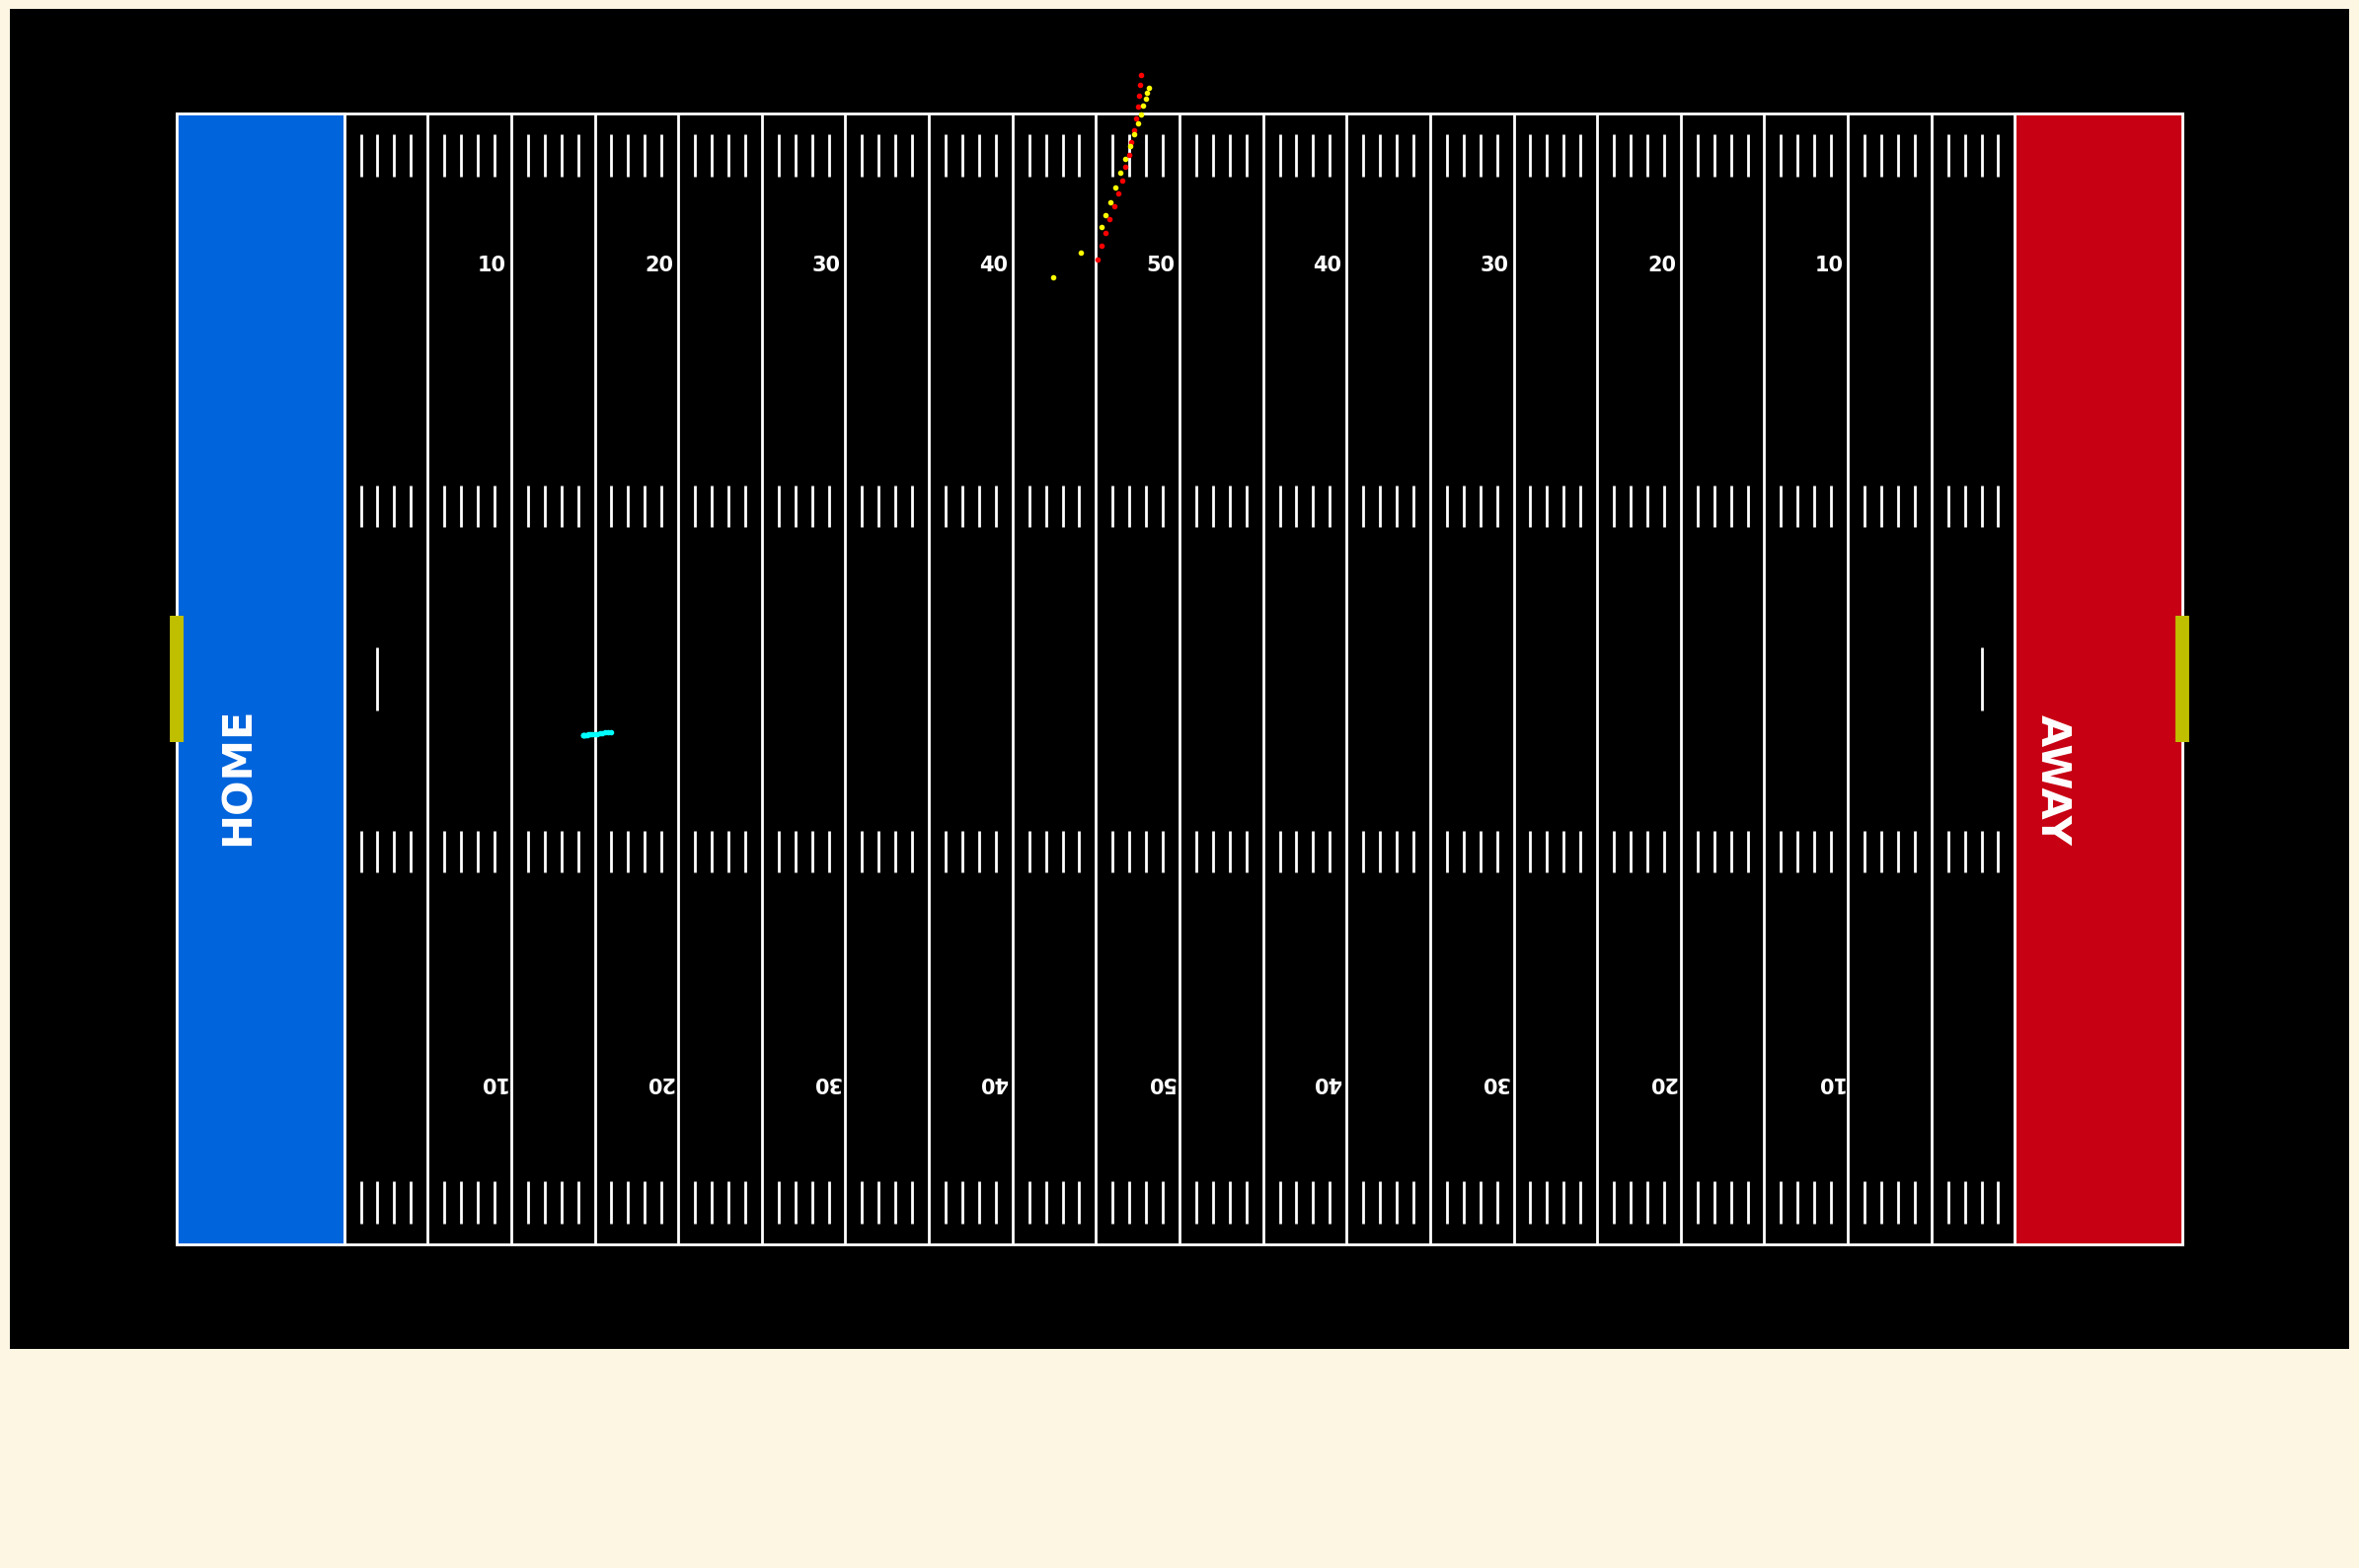

In [332]:
grasscolor="#000000"     #'#3f995b' green is default
fig, ax = drawPitch(grasscolor=grasscolor)
df = nfltracking2024
# displayNmes used need to be involved in this particular play
gameId,playId,displayName,displayName2 = 2022090800, 2307, "Cooper Kupp", "Matthew Stafford"
# ASSUMED TO BE GLOBALLY DEFINED in draw_game_play_position
custom_cycler = (cycler(color=['red','cyan','yellow','magenta']))
# Show QB, track of ball and receiver at the end of this 23-yard pass completion
draw_game_play_position(df, gameId, playId, displayName, ax=ax,displayName2=displayName2)

###  Explaining nfltracking 2024

In [183]:
sampleId = 2022090800
playId = 2307
gameId,displayName = sampleId, "Cooper Kupp"
play_player_bool = (nfltracking2024["gameId"] == gameId) & \
                      (nfltracking2024["playId"] == playId) & \
                          (nfltracking2024["displayName"] == displayName)
new_df = nfltracking2024[play_player_bool]

In [185]:
len(new_df)

16

On this play, We track Cooper Kupp for a total of about 2 secs (`"time"` column) over 16 frames, during which time the ball arrives, he catches it, advances, and is pushed out of bounds (`"event"` column).

In [188]:
new_df[2:-4][['time','event']]

,time,event
45700,2022-09-08 22:08:00.900000,pass_arrived
45701,2022-09-08 22:08:01.000000,NaN
45702,2022-09-08 22:08:01.099999,NaN
45703,2022-09-08 22:08:01.200000,pass_outcome_caught
45704,2022-09-08 22:08:01.299999,first_contact
45705,2022-09-08 22:08:01.400000,NaN
45706,2022-09-08 22:08:01.500000,NaN
45707,2022-09-08 22:08:01.599999,NaN
45708,2022-09-08 22:08:01.700000,NaN
45709,2022-09-08 22:08:01.799999,out_of_bounds


In [333]:
sampleId = 2022090800
playId = 2307
gameId,displayName = sampleId, "Cooper Kupp"
play_bool2 = (nfltracking2024["gameId"] == gameId) & \
                      (nfltracking2024["playId"] == playId)
new_df2 = nfltracking2024[play_bool2]

In [334]:
len(new_df2)

368

Here is the list of players who got tracked on that play.

In [335]:
new_df2['displayName'].unique()

array(['Matthew Stafford', 'Micah Hyde', 'Jordan Poyer', 'Allen Robinson',
       'DaQuan Jones', 'Rob Havenstein', 'Tyler Higbee', 'Cooper Kupp',
       'Matt Milano', 'Tremaine Edmunds', 'Joseph Noteboom',
       'Brian Allen', 'Taron Johnson', 'Coleman Shelton', 'Ed Oliver',
       'Darrell Henderson', 'David Edwards', 'A.J. Epenesa',
       'Dane Jackson', 'Carlos Basham', 'Ben Skowronek',
       'Christian Benford', 'football'], dtype=object)

All 22 players are present, hence a mixture of offensive and defensive players:

Finding a player's position:

In [308]:
# Cant do dN = "Matthew Stafford"
dN = "'Matthew Stafford'"
query = f"displayName ==  {dN}"
players_df.query(query)["position"].values[0]

'QB'

Get all player/position pairs for our play:

In [336]:
player_pos_pairs = [(dN, players_df[players_df["displayName"]== dN]["position"].values[0]) for dN in new_df2['displayName'].unique() 
                    if dN != "football"]
player_pos_pairs

[('Matthew Stafford', 'QB'),
 ('Micah Hyde', 'FS'),
 ('Jordan Poyer', 'SS'),
 ('Allen Robinson', 'WR'),
 ('DaQuan Jones', 'DT'),
 ('Rob Havenstein', 'T'),
 ('Tyler Higbee', 'TE'),
 ('Cooper Kupp', 'WR'),
 ('Matt Milano', 'OLB'),
 ('Tremaine Edmunds', 'ILB'),
 ('Joseph Noteboom', 'T'),
 ('Brian Allen', 'C'),
 ('Taron Johnson', 'CB'),
 ('Coleman Shelton', 'G'),
 ('Ed Oliver', 'DT'),
 ('Darrell Henderson', 'RB'),
 ('David Edwards', 'G'),
 ('A.J. Epenesa', 'DE'),
 ('Dane Jackson', 'CB'),
 ('Carlos Basham', 'DE'),
 ('Ben Skowronek', 'WR'),
 ('Christian Benford', 'CB')]

Here's the defence for example.

In [343]:
defence = "CB DE DT ILB OLB SS FS".split()
buffalo_defence = [(pl,po) for (pl,po) in player_pos_pairs if po in defence]
len(buffalo_defence)

11

Players's teams are not available in the player DF.

As far as I can see, the only way a players team can be inferred is from knowing
which team is on offense (`plays_df['possessionTeam']`) and knowing which positions are positions for the offense (not explicitly represented in the data but a fixed property of the game, i.e., a Wikipedia fact
used above).

Hence we get the following figure for average frames per player on this play:

In [281]:
len(new_df2)/22

16.727272727272727

Repeating this for easy inspection.

In [282]:
new_df2['displayName'].unique()

array(['Matthew Stafford', 'Micah Hyde', 'Jordan Poyer', 'Allen Robinson',
       'DaQuan Jones', 'Rob Havenstein', 'Tyler Higbee', 'Cooper Kupp',
       'Matt Milano', 'Tremaine Edmunds', 'Joseph Noteboom',
       'Brian Allen', 'Taron Johnson', 'Coleman Shelton', 'Ed Oliver',
       'Darrell Henderson', 'David Edwards', 'A.J. Epenesa',
       'Dane Jackson', 'Carlos Basham', 'Ben Skowronek',
       'Christian Benford', 'football'], dtype=object)

Note that the football (either `new_df2["displayName"] == "football"`  or `new_df2["jerseyNumber"] == NaN`) is also tracked:

In [246]:
new_df2[new_df2['displayName']=='football'][:5]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
45938,2022090800,2307,NaN,football,1,2022-09-08 22:08:00.700000,NaN,football,right,52.459999,46.160000,20.389999,5.94,2.07,NaN,NaN,NaN
45939,2022090800,2307,NaN,football,2,2022-09-08 22:08:00.799999,NaN,football,right,54.070000,47.349998,19.790001,6.25,2.01,NaN,NaN,NaN
45940,2022090800,2307,NaN,football,3,2022-09-08 22:08:00.900000,NaN,football,right,55.349998,48.599998,6.750000,0.85,1.79,NaN,NaN,pass_arrived
45941,2022090800,2307,NaN,football,4,2022-09-08 22:08:01.000000,NaN,football,right,55.590000,49.139999,6.790000,0.29,0.59,NaN,NaN,NaN
45942,2022090800,2307,NaN,football,5,2022-09-08 22:08:01.099999,NaN,football,right,55.869999,49.750000,6.760000,0.51,0.68,NaN,NaN,NaN


### Time

Times are date time strings, in particular isoformat strings.

In [270]:
ts = new_df2.loc[45938]['time']
ts

'2022-09-08 22:08:00.700000'

These are easily converted to datetime objects for doing datetime manipulations
like duration computation:

In [272]:
import datetime
datetime.datetime.fromisoformat(ts)

datetime.datetime(2022, 9, 8, 22, 8, 0, 700000)

### Exercises

1.  How far did the ball travel through the air in the pass play displayed above?  Note that means
    use Matthew Stafford's (the QB) coordinates at the time the ball was caught/thrown and Cooper
    Kupp's (the WR) coordinates at the time the ball was caught/thrown.  We'll assume the ball's
    journey takes 0 time since we don't have a time stamp for the event of the ball leaving
    the QB's hands. That in term means that we can assume Stafford's location at the time of the catch was
    the same as the location he threw from. 
    The answer should be a larger number than the officially logged 23 yards shown
    in the plot title above.